# Deep Neural Network for MNIST-recognition


In [1]:
import numpy as np
import pandas as pd
import gzip
import pickle
from abc import ABC, abstractmethod
from typing import Tuple, List, Union
import math
import matplotlib.pyplot as plt
%matplotlib inline

## I. 网络定义


In [2]:
epsilon = 10 ** -3

# 线性层定义
class Layer(ABC):

    @abstractmethod
    def forward(self, x: np.ndarray, train: bool = True) -> np.ndarray:
        pass

    @abstractmethod
    def backward(self, grad_input: np.ndarray) -> np.ndarray:
        pass

class ParamLayer(Layer, ABC):

    def apply_gradients(self, learning_rate: float) -> None:
        pass

    def apply_gradients_rms(self, learning_rate: float, beta: float) -> None:
        pass

    def apply_gradients_nev(self, learning_rate: float, nev: bool, aplha: float) -> None:
        pass

class LinearLayer(ParamLayer):

    def __init__(self, input_dim: int, output_dim: int):
        self.weights = np.random.normal(0.0, 0.1,
                                        size=input_dim * output_dim)
        self.weights = self.weights.reshape(input_dim, output_dim)
        self.weights = self.weights.astype("float32")
        self.biases = np.zeros((1, output_dim)).astype("float32")

        # 前馈变量
        self.x = np.zeros(0)

        # 参数更新变量
        self.grad_biases = np.zeros(0)
        self.grad_weights = np.zeros(0)
        self.Sdw = 0.0 # 累积平方权值
        self.Sdb = 0.0 # 累积平方偏差
        self.eps = 1e-8
        self.Vw = 0.0 # 权值速度
        self.Vb = 0.0 # 偏差速度

    # 前向传播
    def forward(self, x: np.ndarray, train: bool = True, nev: bool=False, alpha: float=0.0) -> np.ndarray:
        self.x = x

        if train and nev: # 使用Nestrov优化时需要临时更新参数
            return (self.x @ (self.weights + alpha * self.Vw)) + (self.biases + alpha * self.Vb)
        else:
            return self.x @ self.weights + self.biases

    # 后向传播
    def backward(self, grad_input: np.ndarray, l2: float) -> np.ndarray:
        self.grad_weights = self.x.T @ grad_input + l2 * self.weights
        self.grad_biases = np.sum(grad_input, axis=0, keepdims=True)
        return grad_input @ self.weights.T

    # SGD更新参数
    def apply_gradients(self, learning_rate: float) -> None:
        self.weights -= learning_rate * self.grad_weights
        self.biases -= learning_rate * self.grad_biases

    # RMSprop更新参数
    def apply_gradients_rms(self, learning_rate: float, beta: float) -> None:
        self.Sdw = beta * self.Sdw + (1 - beta) * (self.grad_weights * self.grad_weights)
        self.Sdb = beta * self.Sdb + (1 - beta) * (self.grad_biases * self.grad_biases)

        self.weights -= (learning_rate / np.sqrt(self.eps + self.Sdw)) * self.grad_weights
        self.biases -= (learning_rate / np.sqrt(self.eps + self.Sdb)) * self.grad_biases

    # Nestrov更新参数
    def apply_gradients_nev(self, learning_rate: float, nev: bool, alpha: float) -> None:
        self.Vw = alpha * self.Vw - learning_rate * self.grad_weights
        self.Vb = alpha * self.Vb - learning_rate * self.grad_biases

        self.weights += self.Vw
        self.biases += self.Vb

# 非线性输出定义
class SigmoidLayer(Layer):

    def __init__(self) -> None:
        self.next_x = np.zeros(0)

    def forward(self, x: np.ndarray, train: bool = True) -> np.ndarray:

        self.next_x = 1 / (np.exp(-x) + 1)
        return self.next_x

    def backward(self, grad_input: np.ndarray) -> np.ndarray:
        return (self.next_x * (1 - self.next_x)) * grad_input

# 交叉熵损失定义
class CrossEntropyLoss(Layer):

    def __init__(self, y: np.ndarray):
        self.y = np.clip(y, epsilon, 1.0 - epsilon)

        # forward params
        self.p = np.zeros(0)

    def forward(self, x: np.ndarray, train: bool = True) -> np.ndarray:
        self.p = np.clip(x, epsilon, 1.0 - epsilon)
        return -(self.y * np.log(self.p) + (1-self.y) * np.log(1 - self.p))

    def backward(self, grad_input: np.ndarray, l2: float, layer=None) -> np.ndarray:
        layer_error = (self.p - self.y) / (self.p - self.p ** 2)
        l2_loss = 0.0
        for i in layer:
            if hasattr(i, 'weights'):
                l2_loss += np.sum(np.square(i.weights))
        l2_loss = l2_loss * l2 / 2
        return layer_error * grad_input + l2_loss

# Btach-Normalization定义
class BatchNormLayer(ParamLayer):

    def __init__(self, dims: int) -> None:
        self.gamma = np.ones((1, dims), dtype="float32")
        self.bias = np.zeros((1, dims), dtype="float32")

        self.running_mean_x = np.zeros(0)
        self.running_var_x = np.zeros(0)

        # 前馈变量
        self.var_x = np.zeros(0)
        self.stddev_x = np.zeros(0)
        self.x_minus_mean = np.zeros(0)
        self.standard_x = np.zeros(0)
        self.num_examples = 0
        self.mean_x = np.zeros(0)
        self.running_avg_gamma = 0.9

        # 参数更新变量
        self.gamma_grad = np.zeros(0)
        self.bias_grad = np.zeros(0)
        self.Sdg = 0.0 # 累积平方权值
        self.Sdb = 0.0 # 累积平方偏差
        self.Vg = 0.0 # 权值速度
        self.Vb = 0.0 # 偏差速度
        self.eps = 1e-8

    def update_running_variables(self) -> None:
        is_mean_empty = np.array_equal(np.zeros(0), self.running_mean_x)
        is_var_empty = np.array_equal(np.zeros(0), self.running_var_x)
        if is_mean_empty != is_var_empty:
            raise ValueError("Mean and Var running averages should be "
                             "initilizaded at the same time")
        if is_mean_empty:
            self.running_mean_x = self.mean_x
            self.running_var_x = self.var_x
        else:
            gamma = self.running_avg_gamma
            self.running_mean_x = gamma * self.running_mean_x + \
                                  (1.0 - gamma) * self.mean_x
            self.running_var_x = gamma * self.running_var_x + \
                                 (1. - gamma) * self.var_x

    def forward(self, x: np.ndarray, train: bool = True, nev: bool = False, alpha: float = 0.0) -> np.ndarray:
        self.num_examples = x.shape[0]
        if train:
            self.mean_x = np.mean(x, axis=0, keepdims=True)
            self.var_x = np.mean((x - self.mean_x) ** 2, axis=0, keepdims=True)
            self.update_running_variables()
        else:
            self.mean_x = self.running_mean_x.copy()
            self.var_x = self.running_var_x.copy()

        self.var_x += epsilon
        self.stddev_x = np.sqrt(self.var_x)
        self.x_minus_mean = x - self.mean_x
        self.standard_x = self.x_minus_mean / self.stddev_x
        if train and nev:
            return (self.gamma + alpha * self.Vg) * self.standard_x + (self.bias + alpha * self.Vb)
        else:
            return self.gamma * self.standard_x + self.bias

    def backward(self, grad_input: np.ndarray) -> np.ndarray:
        standard_grad = grad_input * self.gamma

        var_grad = np.sum(standard_grad * self.x_minus_mean * -0.5 * self.var_x ** (-3/2),
                          axis=0, keepdims=True)
        stddev_inv = 1 / self.stddev_x
        aux_x_minus_mean = 2 * self.x_minus_mean / self.num_examples

        mean_grad = (np.sum(standard_grad * -stddev_inv, axis=0,
                            keepdims=True) +
                            var_grad * np.sum(-aux_x_minus_mean, axis=0,
                            keepdims=True))

        self.gamma_grad = np.sum(grad_input * self.standard_x, axis=0,
                                 keepdims=True)
        self.bias_grad = np.sum(grad_input, axis=0, keepdims=True)

        return standard_grad * stddev_inv + var_grad * aux_x_minus_mean + mean_grad / self.num_examples

    # SGD更新参数
    def apply_gradients(self, learning_rate: float) -> None:
        self.gamma -= learning_rate * self.gamma_grad
        self.bias -= learning_rate * self.bias_grad

    # RMSprop更新参数
    def apply_gradients_rms(self, learning_rate: float, beta: float) -> None:
        self.Sdg = beta * self.Sdg + (1 - beta) * (self.gamma_grad * self.gamma_grad)
        self.Sdb = beta * self.Sdb + (1 - beta) * (self.bias_grad * self.bias_grad)

        self.gamma -= (learning_rate / np.sqrt(self.eps + self.Sdg)) * self.gamma_grad
        self.bias -= (learning_rate / np.sqrt(self.eps + self.Sdb)) * self.bias_grad

    # Nestrov更新参数
    def apply_gradients_nev(self, learning_rate: float, nev: bool, alpha: float) -> None:
        self.Vg = alpha * self.Vg - learning_rate * self.gamma_grad
        self.Vb = alpha * self.Vb - learning_rate * self.bias_grad

        self.gamma += self.Vg
        self.bias += self.Vb

# 全连接网络定义
class NeuralNetwork:

    def __init__(self, layers: List[Layer]):
        self.layers = layers[:]
        self.loss_layer: Union[Layer, None] = None

    def backward_propagation(self, output: np.ndarray, l2: float) -> None:
        grad_input = self.loss_layer.backward(np.ones_like(output), l2, self.layers)
        for layer_index in range(len(self.layers)-1, -1, -1):
            if hasattr(self.layers[layer_index], 'weights'):
                grad_input = self.layers[layer_index].backward(grad_input, l2)
            else:
                grad_input = self.layers[layer_index].backward(grad_input)

    # SGD更新参数
    def update_params(self, learning_rate: float) -> None:
        for layer_index in range(len(self.layers)):
            layer = self.layers[layer_index]
            if isinstance(layer, ParamLayer):
                layer.apply_gradients(learning_rate)

    # RMSprop更新参数
    def update_params_rms(self, learning_rate: float) -> None:
        for layer_index in range(len(self.layers)):
            layer = self.layers[layer_index]
            if isinstance(layer, ParamLayer):
                layer.apply_gradients_rms(learning_rate, beta=0.9)

    # Nestrov更新参数
    def update_params_nev(self, learning_rate: float) -> None:
        for layer_index in range(len(self.layers)):
            layer = self.layers[layer_index]
            if isinstance(layer, ParamLayer):
                layer.apply_gradients_nev(learning_rate, nev=True, alpha=0.9)

    # 计算accuracy
    def evaluate_model(self, test_x: np.ndarray,
                       test_y: np.ndarray) -> Tuple[float, float]:
        """Returns loss and accuracy in the test set"""
        self.loss_layer = CrossEntropyLoss(test_y)
        y_pred = self.predict(test_x)
        y_pred_labels = np.argmax(y_pred, axis=1)
        y_labels = np.argmax(test_y, axis=1)
        loss = self.loss_layer.forward(y_pred)
        accuracy = np.sum(y_labels == y_pred_labels) / test_x.shape[0]
        return float(np.mean(loss)), accuracy

    # 训练
    def fit(self, x_train: np.ndarray, y_train: np.ndarray,
            learning_rate: float, steps: int,
            batch_size: int, x_test: np.ndarray,
            y_test: np.ndarray, l2=0.0, optimizer='sgd') -> np.array:

        self.l2 = l2
        num_examples = x_train.shape[0]
        num_batches = math.ceil(num_examples/batch_size)
        metrics = np.zeros((steps//num_batches, 4))  # loss, accuracy, val_loss, val_accuracy
        random_index = np.linspace(0, num_examples-1, num_examples).astype(int)
        print('training on {} epoch'.format(steps//num_batches))
        for epoch in range(steps//num_batches):
            np.random.shuffle(random_index)
            x_train = x_train[random_index]
            y_train = y_train[random_index]
            for index_batch in range(0, num_examples, batch_size):
                mini_batch_x = x_train[index_batch: index_batch + batch_size]
                mini_batch_y = y_train[index_batch: index_batch + batch_size]
                self.loss_layer = CrossEntropyLoss(mini_batch_y)
                if optimizer == 'nev':
                    y_pred = self.predict(mini_batch_x, train=True, nev=True, alpha=0.9)
                else:
                    y_pred = self.predict(mini_batch_x, train=True)
                self.loss_layer.forward(y_pred)
                self.backward_propagation(y_pred, l2)
                if optimizer == 'sgd':
                    self.update_params(learning_rate)
                elif optimizer == 'rms':
                    self.update_params_rms(learning_rate)
                elif optimizer == 'nev':
                    self.update_params_nev(learning_rate)

            loss, accuracy = self.evaluate_model(x_train, y_train)
            val_loss, val_accuracy = self.evaluate_model(x_test, y_test)
            print('epoch:{}, loss:{}, accuracy:{}, val_loss:{}, val_accuracy:{}'.format(epoch + 1, loss, accuracy,
                                                                                     val_loss, val_accuracy))
            metrics[epoch, :] = loss, accuracy, val_loss, val_accuracy

        return metrics

    # 预测输出
    def predict(self, x_test: np.ndarray, train: bool = False, nev: bool = False, alpha: float = 0.9) -> np.ndarray:
        for layer in self.layers:
            if isinstance(layer, ParamLayer):
                x_test = layer.forward(x_test, train=train, nev=nev, alpha=alpha)
            else:
                x_test = layer.forward(x_test, train=train)
        return x_test

## II. 加载数据



In [3]:
def load_data():
    f = gzip.open('mnist.pkl.gz', 'rb')
    tr_d, va_d, te_d = pickle.load(f, encoding="latin1")
    f.close()

    training_inputs = [np.reshape(x, (784)) for x in tr_d[0]]
    training_results = []
    for j in tr_d[1]:
        e = np.zeros((10,))
        e[j] = 1.0
        training_results.append(e)

    test_inputs = [np.reshape(x, (784)) for x in te_d[0]]
    test_results = []
    for j in te_d[1]:
        e = np.zeros((10,))
        e[j] = 1.0
        test_results.append(e)

    training_inputs, training_results, test_inputs, test_results = np.array(training_inputs), np.array(
        training_results), np.array(test_inputs), np.array(test_results)

    return training_inputs, training_results, test_inputs, test_results

x_train, y_train, x_test, y_test = load_data()

## III. 实验对比


### 1) 通过添加网络层数制造过拟合，并采用L2范数和BN正则化修正


Training Baseline
training on 76 epoch
epoch:1, loss:0.13100331192636835, accuracy:0.837, val_loss:0.1274149096167862, val_accuracy:0.8463
epoch:2, loss:0.0890255573870787, accuracy:0.88312, val_loss:0.08522396681420723, val_accuracy:0.891
epoch:3, loss:0.07622644768173518, accuracy:0.89718, val_loss:0.0732157724959633, val_accuracy:0.9032
epoch:4, loss:0.06945172587401975, accuracy:0.9064, val_loss:0.06648232592746114, val_accuracy:0.9141
epoch:5, loss:0.06681793605243647, accuracy:0.9094, val_loss:0.06424419643373266, val_accuracy:0.9144
epoch:6, loss:0.06115028297840608, accuracy:0.91866, val_loss:0.05894733836224558, val_accuracy:0.9253
epoch:7, loss:0.05837497267179897, accuracy:0.922, val_loss:0.05611801636504033, val_accuracy:0.9255
epoch:8, loss:0.054387653450584085, accuracy:0.92806, val_loss:0.05323154883818759, val_accuracy:0.9294
epoch:9, loss:0.05161966799803125, accuracy:0.93178, val_loss:0.050781434846030905, val_accuracy:0.9334
epoch:10, loss:0.04955827518145136, accura

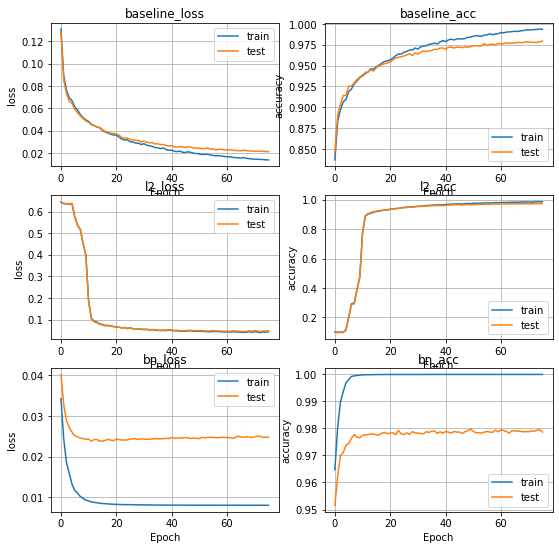

In [4]:
learning_rate = 0.001
batch_size = 128
neurons = 600
steps = 30000

# 基本模型
model_baseline = NeuralNetwork([LinearLayer(x_train.shape[1], neurons),
                                SigmoidLayer(),
                                LinearLayer(neurons, neurons),
                                SigmoidLayer(),
                                LinearLayer(neurons, neurons),
                                SigmoidLayer(),
                                LinearLayer(neurons, y_train.shape[1]),
                                SigmoidLayer()])
# 基本模型使用L2正则化
model_l2 = NeuralNetwork([LinearLayer(x_train.shape[1], neurons),
                          SigmoidLayer(),
                          LinearLayer(neurons, neurons),
                          SigmoidLayer(),
                          LinearLayer(neurons, neurons),
                          SigmoidLayer(),
                          LinearLayer(neurons, y_train.shape[1]),
                          SigmoidLayer()])
# 基本模型使用BN正则化
model_bn = NeuralNetwork([LinearLayer(x_train.shape[1], neurons),
                          SigmoidLayer(),
                          BatchNormLayer(neurons),
                          LinearLayer(neurons, neurons),
                          SigmoidLayer(),
                          BatchNormLayer(neurons),
                          LinearLayer(neurons, neurons),
                          SigmoidLayer(),
                          BatchNormLayer(neurons),
                          LinearLayer(neurons, y_train.shape[1]),
                          SigmoidLayer()])

# 针对3种模型训练
print("Training Baseline")
baseline = model_baseline.fit(x_train, y_train, steps=steps,
                              learning_rate=learning_rate,
                              batch_size=batch_size,
                              x_test=x_test, y_test=y_test)

print("Training Model-L2")
l2 = model_l2.fit(x_train, y_train, steps=steps,
                  learning_rate=learning_rate,
                  batch_size=batch_size,
                  x_test=x_test, y_test=y_test, l2=0.0002)

print("Training Model-BN")
bn = model_bn.fit(x_train, y_train, steps=steps,
                  learning_rate=learning_rate,
                  batch_size=batch_size, x_test=x_test,
                  y_test=y_test)

plt.figure(figsize=(9, 9))

plt.subplot(3, 2, 1)
plt.plot(baseline[:, 0], label='train')
plt.plot(baseline[:, 2], label='test')
plt.title('baseline_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(baseline[:, 1], label='train')
plt.plot(baseline[:, 3], label='test')
plt.title('baseline_acc')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(l2[:, 0], label='train')
plt.plot(l2[:, 2], label='test')
plt.title('l2_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(l2[:, 1], label='train')
plt.plot(l2[:, 3], label='test')
plt.title('l2_acc')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(bn[:, 0], label='train')
plt.plot(bn[:, 2], label='test')
plt.title('bn_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(bn[:, 1], label='train')
plt.plot(bn[:, 3], label='test')
plt.title('bn_acc')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend()

plt.show()

添加网络层数后，在baseline基准模型训练过程中，loss曲线和accuracy曲线出现偏差，训练集准确率大于测试集准确率，出现了过拟合现象，虽然并不是非常明显。
采用L2正则化后，能看到过拟合现象已经解决，loss曲线和accuracy曲线明显重合在一起。
采用BN正则化后，其作用主要为加快训练速度，对过拟合修正的效果较小。



### 2) 通过减少训练数据量制造过拟合，并采用L2范数和BN正则化修正


Training Baseline
training on 1250 epoch
epoch:1, loss:0.32808031097122803, accuracy:0.136, val_loss:0.329359880201337, val_accuracy:0.1135
epoch:2, loss:0.32503963653908374, accuracy:0.136, val_loss:0.3267464885398621, val_accuracy:0.1135
epoch:3, loss:0.3245372913814567, accuracy:0.136, val_loss:0.3262363534864379, val_accuracy:0.1135
epoch:4, loss:0.3240280901893288, accuracy:0.136, val_loss:0.32584302884219113, val_accuracy:0.1135
epoch:5, loss:0.32358571122116975, accuracy:0.136, val_loss:0.32536882460374567, val_accuracy:0.1135
epoch:6, loss:0.32313293102049456, accuracy:0.136, val_loss:0.3249953256417375, val_accuracy:0.1135
epoch:7, loss:0.32269083501954077, accuracy:0.136, val_loss:0.3244929759030532, val_accuracy:0.1135
epoch:8, loss:0.3222539976906963, accuracy:0.155, val_loss:0.3239222110532085, val_accuracy:0.1325
epoch:9, loss:0.32174543424725904, accuracy:0.136, val_loss:0.3233435819383427, val_accuracy:0.1135
epoch:10, loss:0.32138695926293287, accuracy:0.136, val_loss:

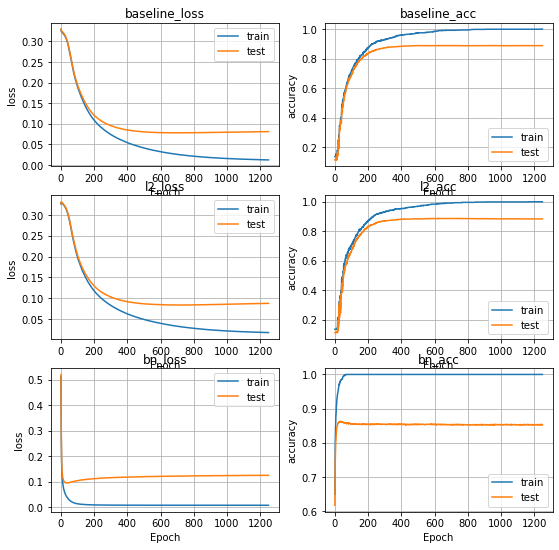

In [5]:
learning_rate = 0.0005
batch_size = 128
neurons = 100
steps = 10000

# 随机抽取1000个样本
state = np.random.get_state()
np.random.shuffle(x_train)
np.random.set_state(state)
np.random.shuffle(y_train)
x_train, y_train = x_train[:1000], y_train[:1000]

# 基本模型
model_baseline = NeuralNetwork([LinearLayer(x_train.shape[1], neurons),
                                SigmoidLayer(),
                                LinearLayer(neurons, neurons),
                                SigmoidLayer(),
                                LinearLayer(neurons, y_train.shape[1]),
                                SigmoidLayer()])

# 基本模型使用L2正则化
model_l2 = NeuralNetwork([LinearLayer(x_train.shape[1], neurons),
                          SigmoidLayer(),
                          LinearLayer(neurons, neurons),
                          SigmoidLayer(),
                          LinearLayer(neurons, y_train.shape[1]),
                          SigmoidLayer()])

# 基本模型使用BN正则化
model_bn = NeuralNetwork([LinearLayer(x_train.shape[1], neurons),
                          SigmoidLayer(),
                          BatchNormLayer(neurons),
                          LinearLayer(neurons, neurons),
                          SigmoidLayer(),
                          BatchNormLayer(neurons),
                          LinearLayer(neurons, y_train.shape[1]),
                          SigmoidLayer()])

print("Training Baseline")
baseline = model_baseline.fit(x_train, y_train, steps=steps,
                              learning_rate=learning_rate,
                              batch_size=batch_size,
                              x_test=x_test, y_test=y_test)

print("Training Model-L2")
l2 = model_l2.fit(x_train, y_train, steps=steps,
                  learning_rate=learning_rate,
                  batch_size=batch_size,
                  x_test=x_test, y_test=y_test, l2=0.001)

print("Training Model-BN")
bn = model_bn.fit(x_train, y_train, steps=steps,
                  learning_rate=learning_rate,
                  batch_size=batch_size, x_test=x_test,
                  y_test=y_test)

plt.figure(figsize=(9, 9))

plt.subplot(3, 2, 1)
plt.plot(baseline[:, 0], label='train')
plt.plot(baseline[:, 2], label='test')
plt.title('baseline_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(baseline[:, 1], label='train')
plt.plot(baseline[:, 3], label='test')
plt.title('baseline_acc')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(l2[:, 0], label='train')
plt.plot(l2[:, 2], label='test')
plt.title('l2_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(l2[:, 1], label='train')
plt.plot(l2[:, 3], label='test')
plt.title('l2_acc')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(bn[:, 0], label='train')
plt.plot(bn[:, 2], label='test')
plt.title('bn_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(bn[:, 1], label='train')
plt.plot(bn[:, 3], label='test')
plt.title('bn_acc')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend()

plt.show()

减少训练数据量后，在baseline基准模型训练过程中，loss曲线和accuracy曲线出现偏差，训练集准确率大于测试集准确率，出现了过拟合现象，虽然并不是非常明显。
采用L2正则化后，loss曲线和accuracy曲线仍然存在细小偏差。对于减少数据量导致的过拟合问题使用L2正则化基本没什么效果，因为l2正则化应用于权重上，这个过拟合的问题是因为数据量的不足而导致的，所以L2正则化起不到什么作用，或者说效果不明显。
采用BN正则化后，其作用主要为加快训练速度，对过拟合修正的效果较小。


### 3) SGD, RMSprop, Nestrov优化训练对比


Training Baseline-sgd
training on 6250 epoch
epoch:1, loss:0.40935016800452323, accuracy:0.136, val_loss:0.41131837706951585, val_accuracy:0.1145
epoch:2, loss:0.3581145821992859, accuracy:0.136, val_loss:0.3595962590864747, val_accuracy:0.1135
epoch:3, loss:0.3398637659441389, accuracy:0.136, val_loss:0.34117141425609837, val_accuracy:0.1135
epoch:4, loss:0.3322706529646814, accuracy:0.136, val_loss:0.3335141720486496, val_accuracy:0.1135
epoch:5, loss:0.32880605303644544, accuracy:0.136, val_loss:0.3300563314909918, val_accuracy:0.1135
epoch:6, loss:0.32711295915862026, accuracy:0.136, val_loss:0.32840000216762716, val_accuracy:0.1135
epoch:7, loss:0.32623376637279244, accuracy:0.136, val_loss:0.3275426458447261, val_accuracy:0.1135
epoch:8, loss:0.32574746669060667, accuracy:0.136, val_loss:0.3270937723769249, val_accuracy:0.1135
epoch:9, loss:0.32545780704655125, accuracy:0.136, val_loss:0.32684203269751233, val_accuracy:0.1135
epoch:10, loss:0.32526696422915163, accuracy:0.136, va

c:\users\junzhao\onedrive\python_project\coursework\venv\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 31181 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\junzhao\onedrive\python_project\coursework\venv\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 20248 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\junzhao\onedrive\python_project\coursework\venv\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 21270 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\junzhao\onedrive\python_project\coursework\venv\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 22120 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\junzhao\onedrive\python_project\coursework\venv\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 30340 missing from current font.
  

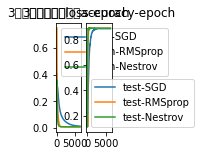

In [6]:
learning_rate = 0.0001
batch_size = 128
neurons = 100
steps = 50000

# SGD优化
model_sgd = NeuralNetwork([LinearLayer(x_train.shape[1], neurons),
                           SigmoidLayer(),
                           LinearLayer(neurons, neurons),
                           SigmoidLayer(),
                           LinearLayer(neurons, y_train.shape[1]),
                           SigmoidLayer()])

# RMSprop优化
model_rms = NeuralNetwork([LinearLayer(x_train.shape[1], neurons),
                           SigmoidLayer(),
                           LinearLayer(neurons, neurons),
                           SigmoidLayer(),
                           LinearLayer(neurons, y_train.shape[1]),
                           SigmoidLayer()])

# Nestrov优化
model_nev = NeuralNetwork([LinearLayer(x_train.shape[1], neurons),
                           SigmoidLayer(),
                           LinearLayer(neurons, neurons),
                           SigmoidLayer(),
                           LinearLayer(neurons, y_train.shape[1]),
                           SigmoidLayer()])

print("Training Baseline-sgd")
sgd = model_sgd.fit(x_train, y_train, steps=steps,
                              learning_rate=learning_rate,
                              batch_size=batch_size,
                              x_test=x_test, y_test=y_test, optimizer='sgd')

print("Training Baseline-rms")
rms = model_rms.fit(x_train, y_train, steps=steps,
                  learning_rate=learning_rate,
                  batch_size=batch_size,
                  x_test=x_test, y_test=y_test, optimizer='rms')

print("Training Baseline-nev")
nev = model_nev.fit(x_train, y_train, steps=steps,
                  learning_rate=learning_rate,
                  batch_size=batch_size, x_test=x_test,
                  y_test=y_test, optimizer='nev')

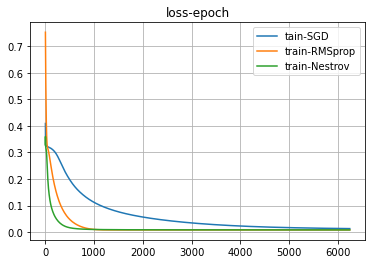

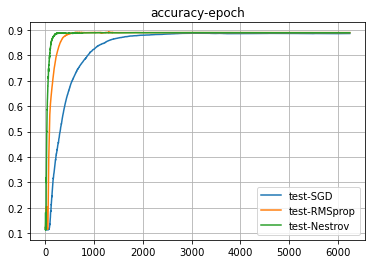

In [13]:
plt.figure()
plt.plot(sgd[:, 0], label='tain-SGD')
plt.plot(rms[:, 0], label='train-RMSprop')
plt.plot(nev[:, 0], label='train-Nestrov')
plt.title('loss-epoch')
plt.grid()
plt.legend()

plt.figure()
plt.plot(sgd[:, 3], label='test-SGD')
plt.plot(rms[:, 3], label='test-RMSprop')
plt.plot(nev[:, 3], label='test-Nestrov')
plt.title('accuracy-epoch')
plt.grid()
plt.legend()

plt.show()

由loss-epoch曲线对比可以看出，收敛速度Nestrov > RMSprop > SGD。
由accuracy-epoch曲线对比可以看出，最终的测试准确度3种训练方法效果相近。